In [3]:
import pandas as pd
from prophet import Prophet
from tqdm import tqdm

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar ventas por producto y mes
df_agg = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Contar meses con ventas y total de meses por producto
ventas_x_prod = df_agg.groupby('product_id')['tn'].apply(lambda x: (x > 0).sum())
meses_totales = df_agg.groupby('product_id')['periodo'].count()

# 4. Categorizar productos
productos_ventas_bajas = ventas_x_prod[ventas_x_prod < 6].index.tolist()
productos_con_pocos_meses = meses_totales[meses_totales < 12].index.tolist()

# 5. Filtrar válidos
productos_validos = [
    prod for prod in df_agg['product_id'].unique()
    if prod not in productos_ventas_bajas and prod not in productos_con_pocos_meses
]

# 6. Predicción Prophet
resultados = []

for prod in tqdm(productos_validos):
    df_prod = df_agg[df_agg['product_id'] == prod].copy()
    df_prod = df_prod.rename(columns={'periodo': 'ds', 'tn': 'y'})
    df_prod = df_prod[['ds', 'y']].sort_values('ds')
    df_prod = df_prod.set_index('ds').asfreq('MS').reset_index()

    try:
        model = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False
        )
        model.fit(df_prod)

        future = model.make_future_dataframe(periods=2, freq='MS')
        forecast = model.predict(future)

        pred_feb = forecast[forecast['ds'] == '2020-02-01']['yhat'].values[0]
        resultados.append((prod, pred_feb))

    except Exception:
        resultados.append((prod, 0.0))

# 7. Guardar resultados
df_resultado = pd.DataFrame(resultados, columns=['product_id', 'tn_predicho'])
df_resultado.to_csv("prediccion_feb2020_prophet_CORREGIDO2.csv", index=False)

# 8. Generar informe
total = df_agg['product_id'].nunique()
procesados = len(productos_validos)
descartados = total - procesados

print("\n📋 INFORME FINAL")
print("────────────────────────────")
print(f"🔢 Total de productos:            {total}")
print(f"✅ Procesados con Prophet:        {procesados}")
print(f"❌ Descartados:                   {descartados}")
print(f"   └─ Por pocas ventas (>0):      {len(productos_ventas_bajas)}")
print(f"   └─ Por pocos meses de datos:   {len(productos_con_pocos_meses)}")

# (Opcional) Guardar productos descartados para auditar
df_descartes = pd.DataFrame({
    'product_id': list(set(productos_ventas_bajas + productos_con_pocos_meses)),
    'motivo': ['ventas < 6' if pid in productos_ventas_bajas else 'menos de 12 meses' for pid in set(productos_ventas_bajas + productos_con_pocos_meses)]
})
df_descartes.to_csv("productos_descartados_prophet.csv", index=False)
print("🗃️ Archivo generado: productos_descartados_prophet.csv")


100%|██████████| 756/756 [01:31<00:00,  8.23it/s]


📋 INFORME FINAL
────────────────────────────
🔢 Total de productos:            780
✅ Procesados con Prophet:        756
❌ Descartados:                   24
   └─ Por pocas ventas (>0):      24
   └─ Por pocos meses de datos:   0
🗃️ Archivo generado: productos_descartados_prophet.csv


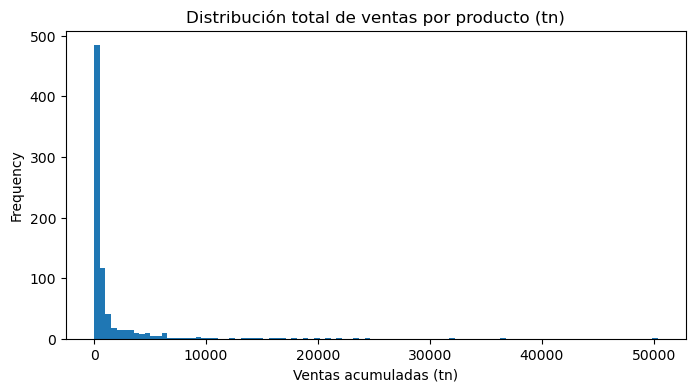

In [4]:
import matplotlib.pyplot as plt

df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

agg = df.groupby('product_id')['tn'].sum()
agg.plot.hist(bins=100, figsize=(8,4))
plt.title("Distribución total de ventas por producto (tn)")
plt.xlabel("Ventas acumuladas (tn)")
plt.show()


In [7]:
import pandas as pd
from prophet import Prophet
from tqdm import tqdm

# 1. Cargar dataset
df = pd.read_csv("datasetwg.csv")
df['periodo'] = pd.to_datetime(df['periodo'])

# 2. Agregar por producto
df_agg = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# 3. Lista de productos únicos
productos = df_agg['product_id'].unique()

# 4. Listas para resultados y descartes
resultados = []
descartes = []

# 5. Loop por producto
for prod in tqdm(productos):
    df_prod = df_agg[df_agg['product_id'] == prod].copy()
    df_prod = df_prod.rename(columns={'periodo': 'ds', 'tn': 'y'})
    df_prod = df_prod[['ds', 'y']].sort_values('ds')

    # Frecuencia mensual
    df_prod = df_prod.set_index('ds').asfreq('MS').reset_index()

    # Cantidad de períodos positivos
    positivos = df_prod[df_prod['y'] > 0]

    if len(positivos) > 18:
        try:
            model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False
            )
            model.fit(df_prod)

            future = model.make_future_dataframe(periods=2, freq='MS')
            forecast = model.predict(future)
            pred_feb = forecast[forecast['ds'] == '2020-02-01']['yhat'].values[0]
            resultados.append((prod, pred_feb))

        except Exception as e:
            # Si falla Prophet, usamos media positiva como fallback
            mean_pos = positivos['y'].mean()
            resultados.append((prod, mean_pos))
            descartes.append((prod, 'Fallo Prophet, uso media positiva'))

    else:
        # Si tiene pocos positivos, usar la media positiva como predicción
        mean_pos = positivos['y'].mean() if len(positivos) > 0 else 0.0
        resultados.append((prod, mean_pos))
        descartes.append((prod, 'Menos de 19 períodos positivos'))

# 6. Exportar predicciones
df_pred = pd.DataFrame(resultados, columns=['product_id', 'tn_predicho'])
df_pred.to_csv("prediccion_feb2020_prophet_FILTRADO.csv", index=False)

# 7. Exportar descartados
df_desc = pd.DataFrame(descartes, columns=['product_id', 'motivo'])
df_desc.to_csv("productos_descartados_prophet.csv", index=False)

# 8. Informe
print("\n📋 INFORME FINAL - PROPHET FILTRADO")
print("────────────────────────────────────────")
print(f"🔢 Total de productos:        {len(productos)}")
print(f"✅ Con Prophet aplicado:      {len(productos) - len(df_desc)}")
print(f"⚠️  Usaron media positiva:     {len(df_desc)}")
print("🗃️ Archivos: predicción y descartes exportados.")


100%|██████████| 780/780 [01:05<00:00, 11.82it/s]


📋 INFORME FINAL - PROPHET FILTRADO
────────────────────────────────────────
🔢 Total de productos:        780
✅ Con Prophet aplicado:      0
⚠️  Usaron media positiva:     780
🗃️ Archivos: predicción y descartes exportados.
